## version 2 of the corona virus tweets text-classfication !

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence

from keras.models import Sequential

from sklearn.metrics import classification_report, f1_score
import io
import os

In [2]:
train = pd.read_csv("./data/Corona_NLP_train.csv", encoding="latin")
test  = pd.read_csv("./data/Corona_NLP_test.csv")

In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Let's dive into, explore &  understand Our Data 

### EDA => (Exploratory Data analysis)

In [5]:
(train.shape[0] , test.shape[0])

(41157, 3798)

In [6]:
data_len = 44955
test_size = (3798* 100) / data_len
train_size = (41157 * 100) / data_len
print("test portion of the full data is :",round(test_size,2),"%")
print("train portion of the full data is :",round(train_size,2),"%")

test portion of the full data is : 8.45 %
train portion of the full data is : 91.55 %


Almost for training : 90% , for testing: 10%

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


All the features are objects means String except the username & screename which are not usefull for our model, specifically the `UserName` feature column

In [9]:
train.drop("UserName", axis=1, inplace=True)
test.drop("UserName", axis=1, inplace=True)

In [10]:
train["Location"].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [11]:
train["Location"].value_counts().nlargest(20)

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
Name: Location, dtype: int64

<AxesSubplot:>

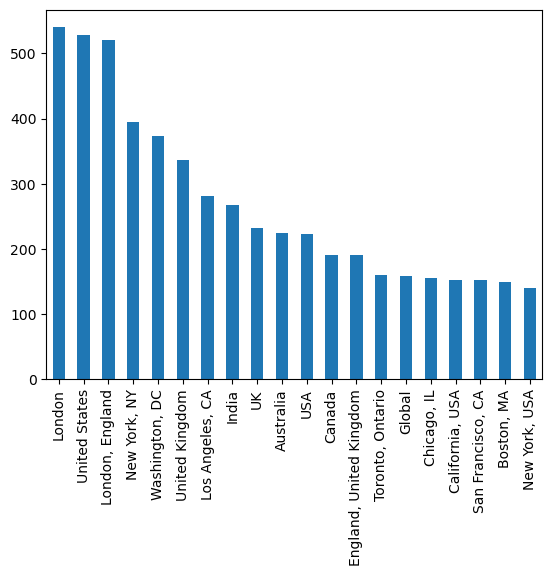

In [12]:
train["Location"].value_counts().nlargest(20).plot(kind='bar')

##  For now let's check the `TweetAt` feature 

In [14]:
train["TweetAt"] = pd.to_datetime(train["TweetAt"])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19-03-2020' in DD/MM/YYYY format. Provide format or specif

In [15]:
tweets_per_day = train["TweetAt"].dt.strftime("%m-%d").value_counts().sort_index().reset_index(name='counts')

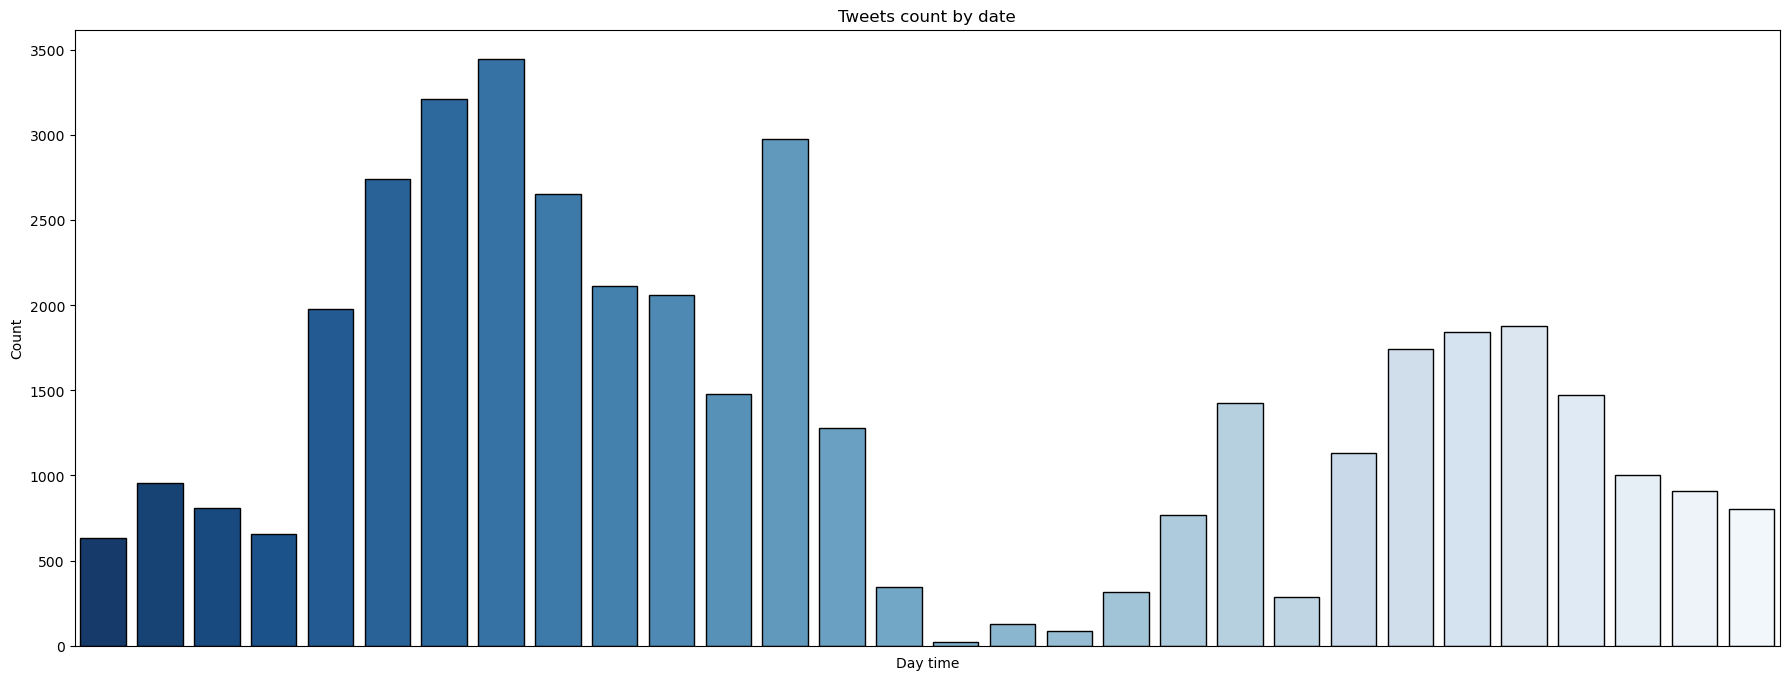

In [18]:
## Visualize the tweets count per day

plt.figure(figsize=(22,8))
ax = sns.barplot(x='index',y='counts', data=tweets_per_day, edgecolor= 'black', ci=False, palette='Blues_r')
plt.title("Tweets count by date")
plt.xticks([])
plt.xlabel("Day time")
plt.ylabel("Count")

plt.show()

In [19]:
train["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

<AxesSubplot:>

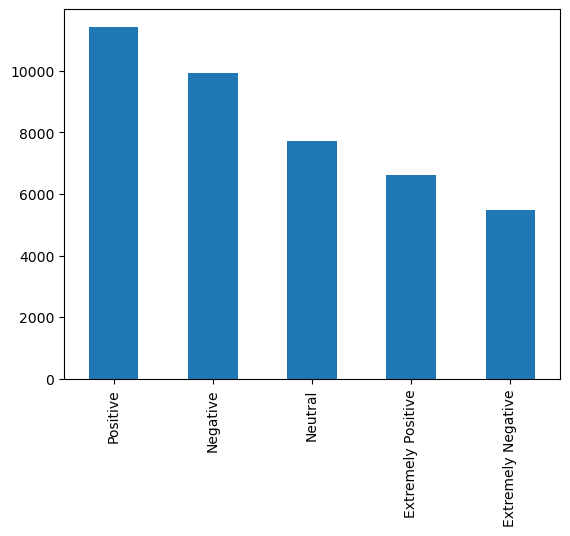

In [20]:
train["Sentiment"].value_counts().plot.bar()

#### Now another phase , is the preprocessing

In [21]:
# Check null values in the training data
train.isna().sum()

ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [22]:
# Check null values in the test data
test.isna().sum()

ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

<AxesSubplot:>

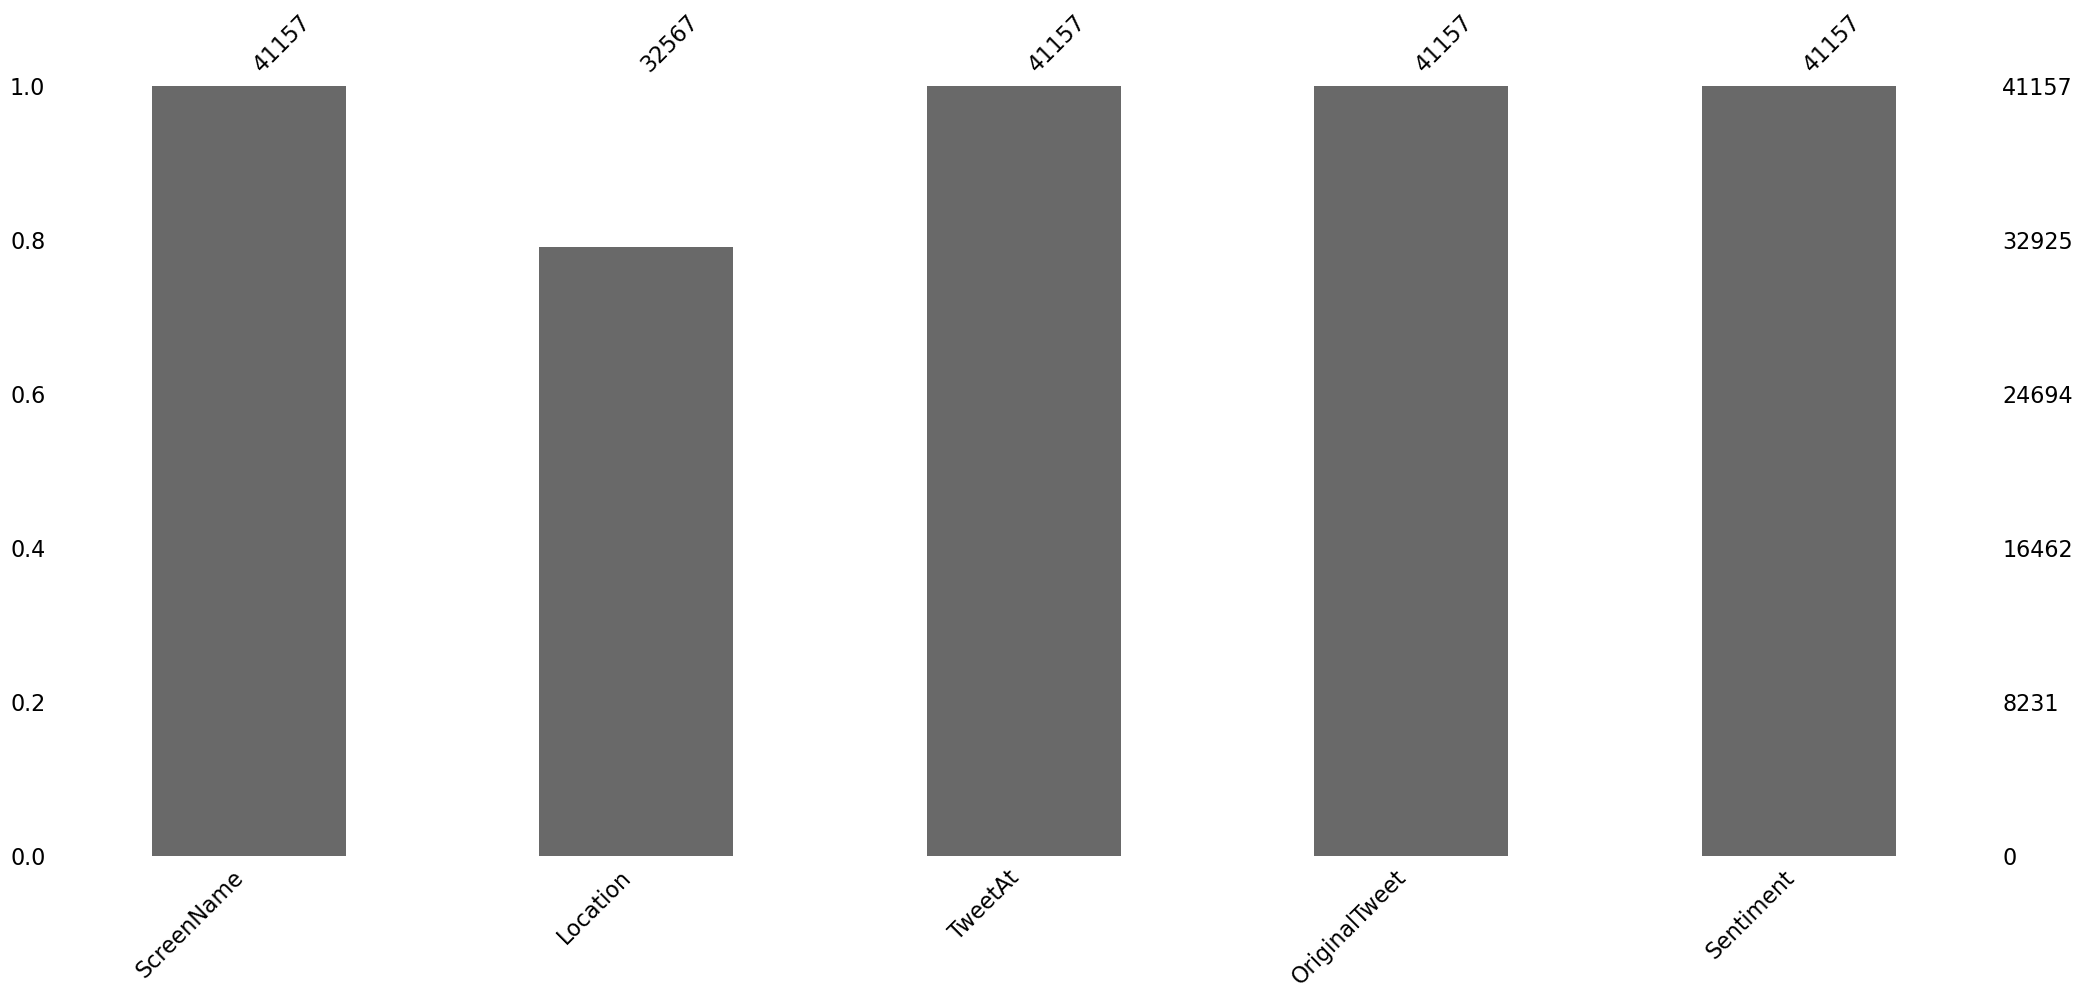

In [23]:
msno.bar(train)

<AxesSubplot:>

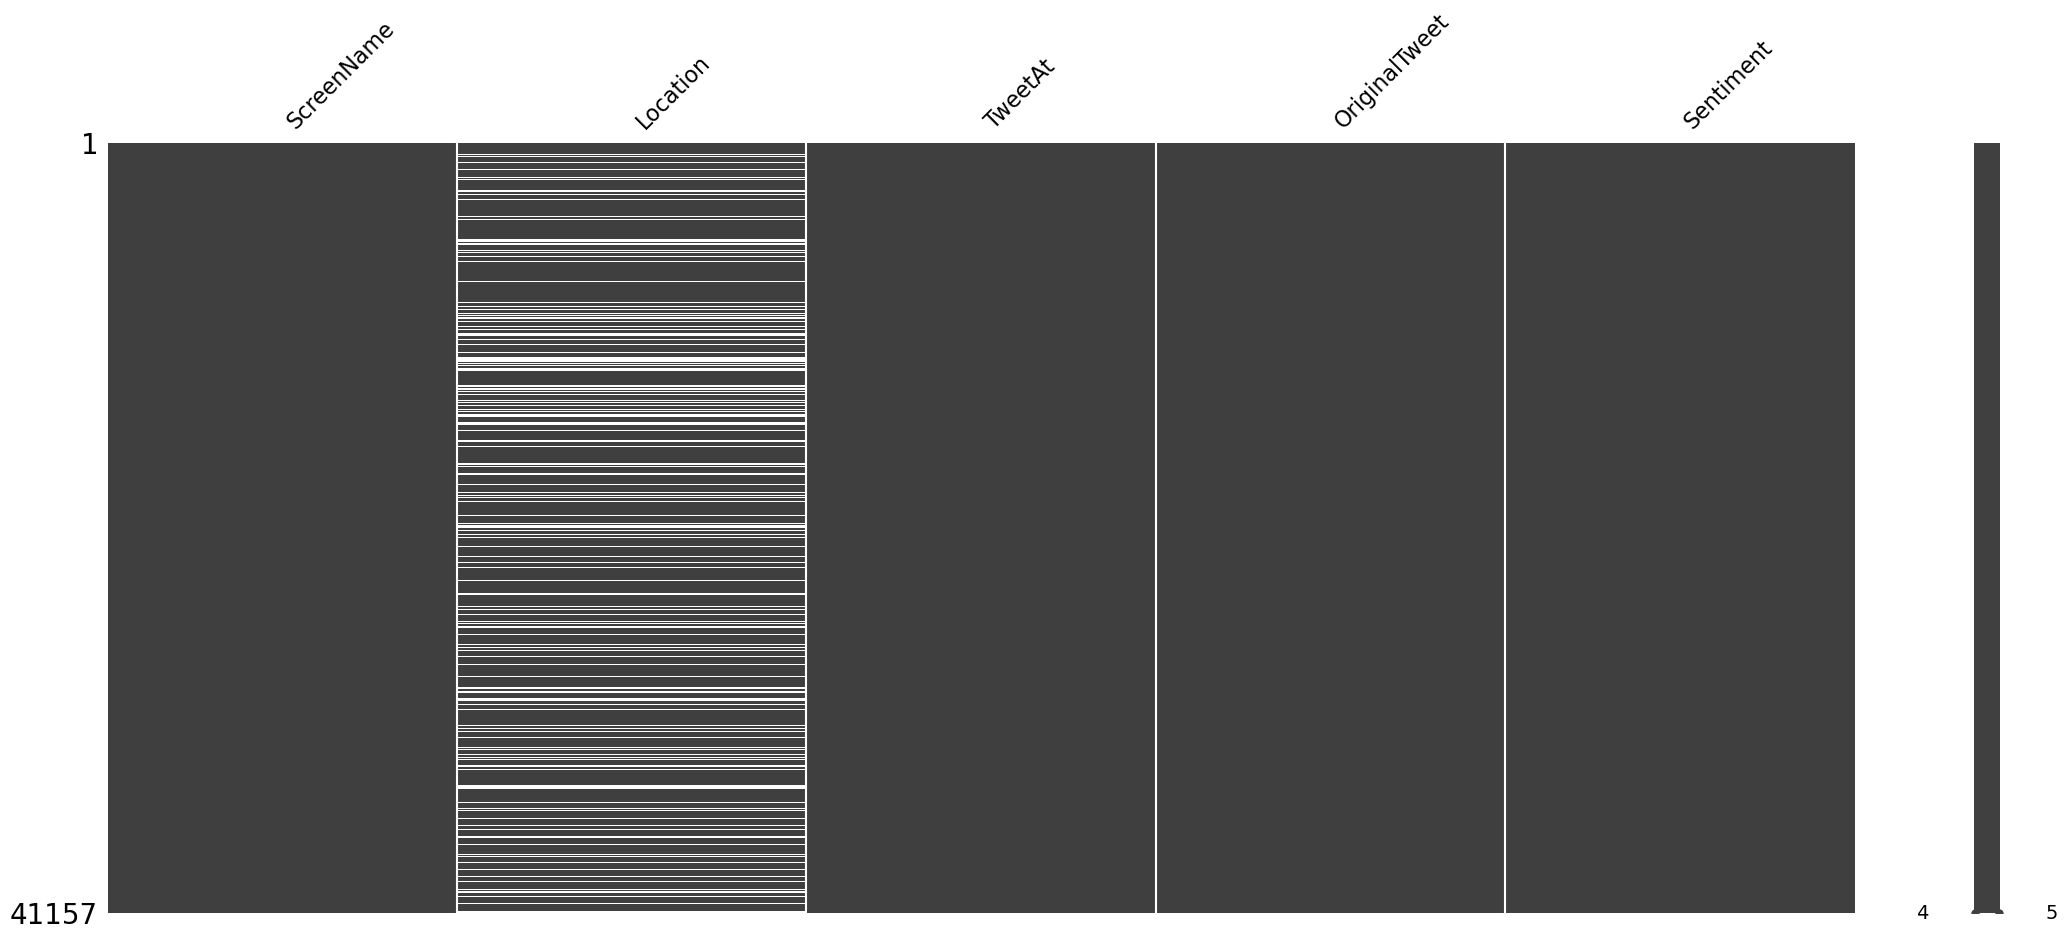

In [24]:
msno.matrix(train)

In [27]:
missing_values_train = train.isna().sum()
percent_train_missing_values = missing_values_train/len(train) * 100
missing_values_train= pd.concat([missing_values_train, percent_train_missing_values], axis=1)
missing_values_train.columns= ["Num. of missing values",'% of missing values']
missing_values_train 

,Num. of missing values,% of missing values
ScreenName,0,0.000000
Location,8590,20.871298
TweetAt,0,0.000000
OriginalTweet,0,0.000000
Sentiment,0,0.000000


In [29]:
missing_values_test = test.isna().sum()
percent_test_missing_values = missing_values_test/len(test) * 100
missing_values_test = pd.concat(
    [missing_values_test, percent_test_missing_values], axis=1)
missing_values_test.columns = [
    "Num. of missing values", '% of missing values']
round(missing_values_test,2)

,Num. of missing values,% of missing values
ScreenName,0,0.00
Location,834,21.96
TweetAt,0,0.00
OriginalTweet,0,0.00
Sentiment,0,0.00


In [30]:
train1 = train.copy()

In [32]:
train1.dropna(subset=["Location"], how="any", inplace=True)
train1.Location.isna().sum()

0

In [33]:
test1 = test.copy()
test1.dropna(subset=["Location"], how='any', inplace=True)
test1.Location.isna().sum()

0

In [34]:
train.shape , train1.shape

((41157, 5), (32567, 5))

In [36]:
print("Deleted train missing values : ",train.shape[0] - train1.shape[0])

Deleted items :  8590


In [38]:
test.shape , test1.shape

((3798, 5), (2964, 5))

In [39]:
print("Deleted test missing values : ", test.shape[0] - test1.shape[0])

Deleted test missing values :  834


#### Now remove the unwanted text or puncs or numbers . . .

In [40]:
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Lower casing


def lower(text):
    low_text = text.lower()
    return low_text

# Number removal


def remove_num(text):
    remove = re.sub(r'\d+', '', text)
    return remove


def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str


train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_urls(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_html(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: lower(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_num(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(
    lambda x: punctuation_removal(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_urls(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_html(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: lower(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_num(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(
    lambda x: punctuation_removal(x))

In [41]:
train["text_length"] = train["OriginalTweet"].apply(len)

In [42]:
train.head()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text_length
0,48751,London,2020-03-16,menyrbie philgahan chrisitv and and,Neutral,38
1,48752,UK,2020-03-16,advice talk to your neighbours family to excha...,Positive,237
2,48753,Vagabonds,2020-03-16,coronavirus australia woolworths to give elder...,Positive,103
3,48754,NaN,2020-03-16,my food stock is not the only one which is emp...,Positive,260
4,48755,NaN,2020-03-16,me ready to go at supermarket during the covid...,Extremely Negative,267


<AxesSubplot:>

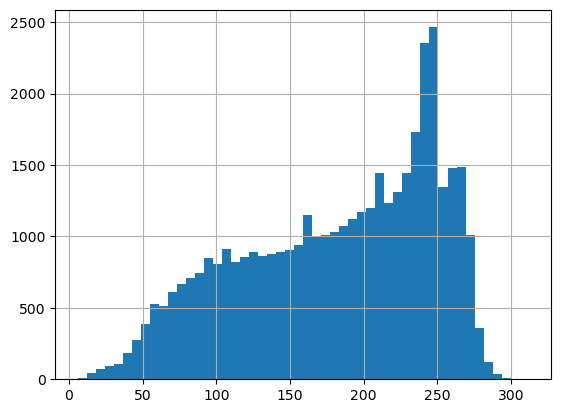

In [46]:
train["text_length"].hist(bins=50)

<Figure size 5000x700 with 0 Axes>

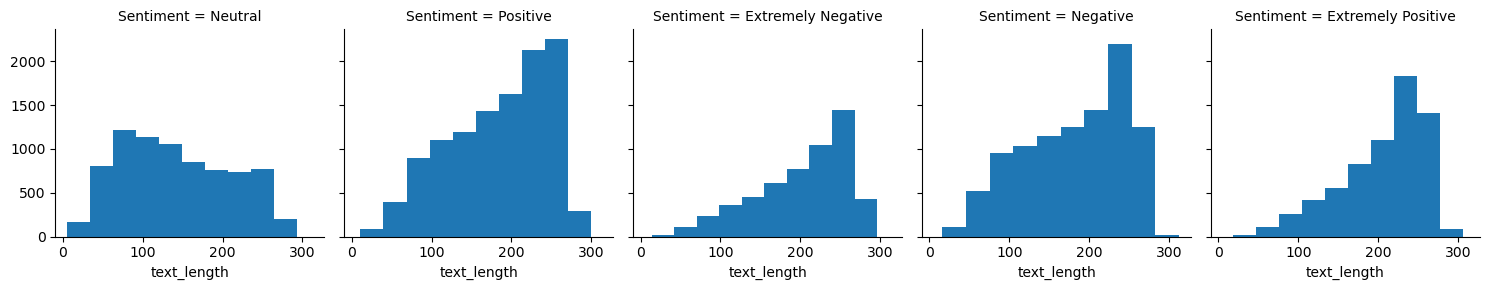

In [47]:
## Filter the text length by Sentiment
plt.figure(figsize=(50,7))
sns.FacetGrid(train, col="Sentiment").map(plt.hist, 'text_length')


In [48]:
y = pd.get_dummies(train["Sentiment"])

#### Apply the Onehot encoder for the Sentiment feature ( 5 classes ) 

In [50]:
y

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
41152,0,0,0,1,0
41153,1,0,0,0,0
41154,0,0,0,0,1
41155,0,0,0,1,0


In [51]:
x = train["OriginalTweet"]

In [52]:
test["text_length"] = test["OriginalTweet"].apply(len)

In [53]:
ytest = pd.get_dummies(test["Sentiment"])
ytest

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,1,0,0,0,0
1,0,0,0,0,1
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
3793,0,0,0,0,1
3794,0,0,1,0,0
3795,0,0,0,1,0
3796,1,0,0,0,0


Now we need a text vectorizer

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x , y, test_size=0.2, random_state=42)

In [57]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((32925,), (8232,), (32925, 5), (8232, 5))

#### Tokenization our data text - features 

In [58]:
tokenizer = Tokenizer(num_words = 1000)

In [59]:
tokenizer.fit_on_texts(X_train)

In [60]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train

[[939, 307, 51, 8, 16, 4, 905, 4, 4, 4, 3, 1, 12, 85, 2, 59],
 [349, 8, 280, 2, 6, 138, 26, 7, 940, 13, 1, 132, 281, 218, 6, 4],
 [3, 12, 47, 8, 31, 1, 91, 9, 104, 1, 508, 392, 127],
 [14,
  64,
  128,
  23,
  7,
  11,
  85,
  2,
  69,
  7,
  460,
  204,
  40,
  75,
  69,
  7,
  20,
  3,
  30,
  21,
  230,
  4,
  201,
  15,
  225,
  2,
  374,
  3,
  8],
 [39,
  10,
  560,
  41,
  2,
  387,
  48,
  25,
  149,
  63,
  2,
  387,
  101,
  23,
  76,
  47,
  3,
  47,
  3,
  171,
  12,
  7,
  2,
  39,
  39,
  19,
  393,
  592,
  35,
  941,
  65,
  44],
 [981, 21, 1, 223, 36, 2, 824, 19, 6, 27, 67, 93, 170, 19, 18],
 [19,
  267,
  35,
  31,
  525,
  5,
  181,
  2,
  79,
  97,
  436,
  19,
  3,
  43,
  2,
  5,
  83,
  54,
  1,
  141],
 [8, 90, 150, 4, 90, 18, 53, 256, 27, 6, 761, 2, 236, 825, 3],
 [546, 43, 13, 190, 24, 4, 925, 211, 925, 4, 57, 2, 43, 13, 3, 77, 607, 9],
 [38,
  24,
  22,
  193,
  5,
  1,
  130,
  103,
  38,
  826,
  1,
  189,
  246,
  8,
  1,
  22,
  674,
  38,
  7,
  762,
  4

In [61]:
X_test = tokenizer.texts_to_sequences(X_test)

In [62]:
total_train = [len(text) for text in X_train]
total_test = [len(text) for text in X_test]

In [65]:
total_train

[16,
 16,
 13,
 29,
 32,
 15,
 20,
 15,
 18,
 23,
 19,
 22,
 36,
 29,
 27,
 30,
 22,
 23,
 31,
 30,
 8,
 35,
 37,
 31,
 46,
 10,
 26,
 34,
 45,
 5,
 24,
 26,
 4,
 4,
 31,
 15,
 30,
 22,
 5,
 39,
 8,
 19,
 21,
 7,
 32,
 29,
 41,
 22,
 18,
 17,
 38,
 18,
 26,
 33,
 10,
 13,
 30,
 7,
 31,
 24,
 27,
 22,
 14,
 7,
 12,
 4,
 33,
 10,
 17,
 16,
 16,
 30,
 10,
 24,
 26,
 27,
 20,
 5,
 22,
 24,
 21,
 31,
 35,
 7,
 34,
 35,
 37,
 14,
 23,
 11,
 25,
 21,
 3,
 40,
 25,
 16,
 25,
 32,
 14,
 9,
 32,
 37,
 33,
 21,
 8,
 6,
 5,
 24,
 31,
 20,
 10,
 12,
 33,
 8,
 27,
 11,
 22,
 43,
 32,
 33,
 40,
 13,
 38,
 41,
 29,
 17,
 10,
 34,
 22,
 32,
 22,
 9,
 12,
 19,
 5,
 33,
 19,
 21,
 26,
 37,
 31,
 35,
 21,
 28,
 19,
 46,
 34,
 10,
 21,
 16,
 11,
 16,
 23,
 7,
 13,
 9,
 9,
 34,
 32,
 14,
 12,
 31,
 33,
 46,
 19,
 16,
 29,
 29,
 21,
 5,
 33,
 17,
 33,
 27,
 22,
 30,
 10,
 11,
 29,
 35,
 29,
 26,
 21,
 5,
 24,
 23,
 9,
 22,
 47,
 38,
 12,
 30,
 22,
 4,
 20,
 27,
 21,
 38,
 22,
 15,
 26,
 27,
 47,
 3,
 15,
 13

In [66]:
total_test

[29,
 25,
 27,
 37,
 29,
 5,
 34,
 13,
 17,
 44,
 22,
 20,
 19,
 21,
 20,
 42,
 28,
 14,
 13,
 27,
 26,
 17,
 9,
 5,
 15,
 18,
 25,
 21,
 5,
 5,
 11,
 13,
 22,
 20,
 22,
 26,
 26,
 12,
 31,
 24,
 39,
 15,
 19,
 23,
 31,
 7,
 6,
 21,
 18,
 20,
 24,
 38,
 29,
 44,
 29,
 31,
 17,
 16,
 15,
 30,
 19,
 25,
 17,
 12,
 12,
 15,
 12,
 30,
 20,
 34,
 22,
 19,
 24,
 27,
 40,
 9,
 34,
 19,
 36,
 14,
 4,
 29,
 24,
 18,
 19,
 33,
 34,
 13,
 37,
 19,
 19,
 21,
 35,
 17,
 41,
 24,
 10,
 27,
 27,
 27,
 34,
 25,
 31,
 7,
 18,
 39,
 13,
 22,
 17,
 24,
 21,
 10,
 39,
 9,
 15,
 13,
 36,
 37,
 11,
 4,
 10,
 14,
 29,
 10,
 23,
 25,
 12,
 21,
 18,
 23,
 6,
 26,
 13,
 23,
 34,
 16,
 23,
 25,
 13,
 26,
 5,
 15,
 18,
 27,
 18,
 13,
 24,
 11,
 17,
 32,
 28,
 18,
 27,
 26,
 44,
 24,
 7,
 12,
 29,
 19,
 16,
 16,
 44,
 6,
 28,
 39,
 23,
 10,
 24,
 37,
 24,
 11,
 31,
 28,
 11,
 30,
 31,
 31,
 28,
 13,
 18,
 32,
 6,
 27,
 12,
 15,
 11,
 32,
 17,
 14,
 12,
 10,
 40,
 6,
 19,
 26,
 40,
 11,
 36,
 38,
 18,
 9,
 46,
 6,


(array([7.400e+01, 2.330e+02, 6.610e+02, 1.240e+03, 1.533e+03, 1.768e+03,
        1.870e+03, 1.845e+03, 2.037e+03, 2.048e+03, 2.283e+03, 2.265e+03,
        2.235e+03, 2.341e+03, 1.156e+03, 2.030e+03, 1.830e+03, 1.549e+03,
        1.279e+03, 9.570e+02, 6.740e+02, 4.380e+02, 2.880e+02, 1.620e+02,
        6.700e+01, 4.400e+01, 9.000e+00, 7.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.        ,  1.93333333,  3.86666667,  5.8       ,  7.73333333,
         9.66666667, 11.6       , 13.53333333, 15.46666667, 17.4       ,
        19.33333333, 21.26666667, 23.2       , 25.13333333, 27.06666667,
        29.        , 30.93333333, 32.86666667, 34.8       , 36.73333333,
        38.66666667, 40.6       , 42.53333333, 44.46666667, 46.4       ,
        48.33333333, 50.26666667, 52.2       , 54.13333333, 56.06666667,
        58.        ]),
 <BarContainer object of 30 artists>)

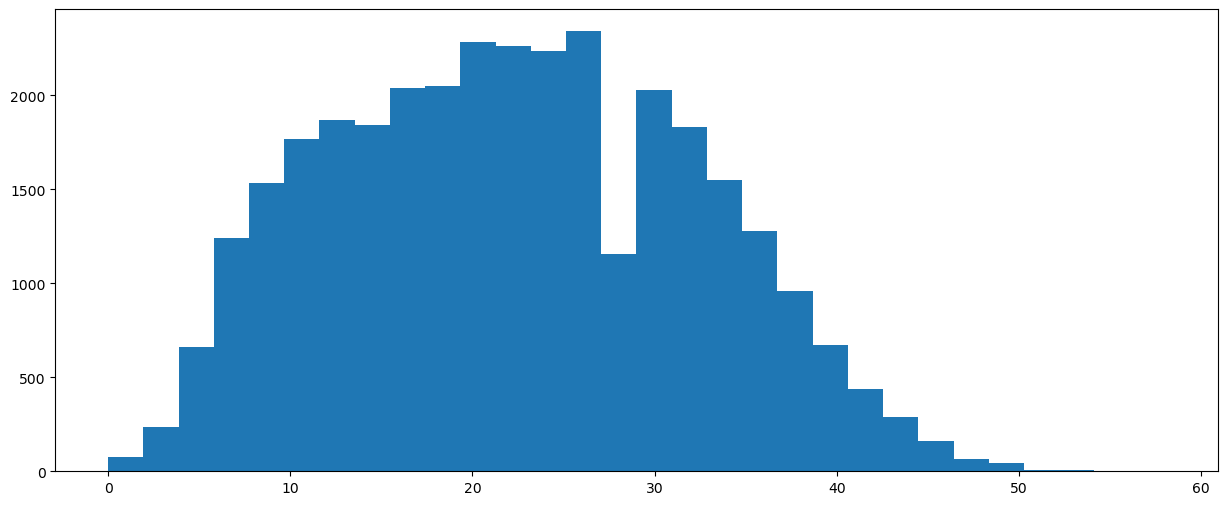

In [68]:
plt.figure(figsize=(15,6))
plt.hist(total_train, bins=30)

(array([ 26.,  58., 168., 269., 423., 209., 460., 491., 510., 530., 539.,
        272., 564., 601., 547., 552., 481., 206., 380., 281., 235., 163.,
        114.,  44.,  63.,  27.,  13.,   4.,   1.,   1.]),
 array([ 0.        ,  1.83333333,  3.66666667,  5.5       ,  7.33333333,
         9.16666667, 11.        , 12.83333333, 14.66666667, 16.5       ,
        18.33333333, 20.16666667, 22.        , 23.83333333, 25.66666667,
        27.5       , 29.33333333, 31.16666667, 33.        , 34.83333333,
        36.66666667, 38.5       , 40.33333333, 42.16666667, 44.        ,
        45.83333333, 47.66666667, 49.5       , 51.33333333, 53.16666667,
        55.        ]),
 <BarContainer object of 30 artists>)

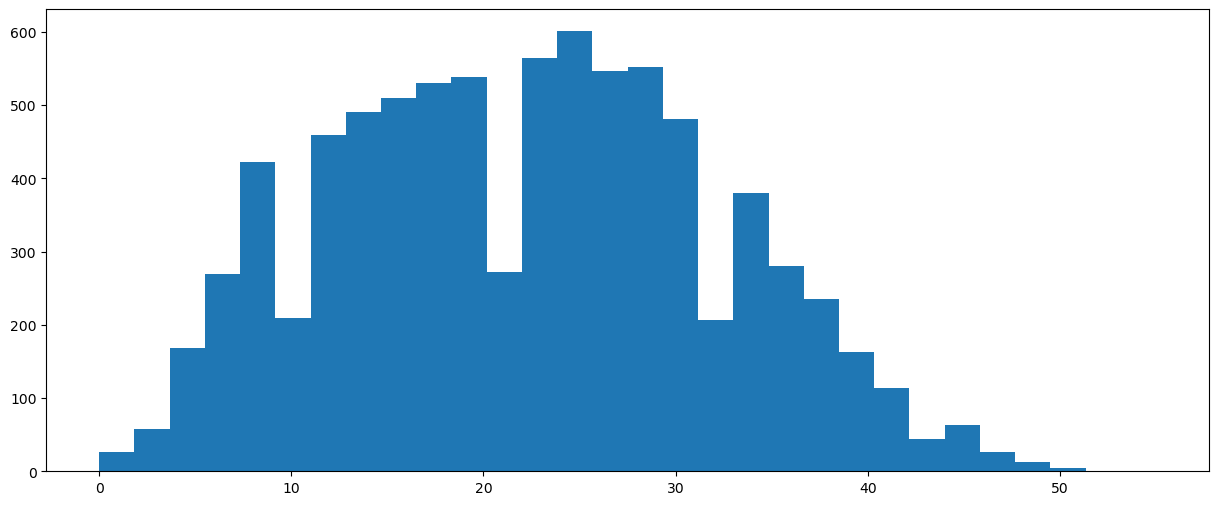

In [69]:
plt.figure(figsize=(15, 6))
plt.hist(total_test, bins=30)

In [71]:
max_words = 28

X_train = sequence.pad_sequences(X_train, maxlen= max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [74]:
total = [len(text) for text in X_train]
total

[28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,


## **Now we need to define and buld Our model using Keras API**

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Input, Conv1D, Dropout, MaxPool1D, GlobalAvgPool1D
from keras.layers import BatchNormalization, Embedding, LSTM, Bidirectional, Activation
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping
from keras.optimizers import Adam

In [83]:
model = Sequential()

model.add(Embedding(10000, 150, input_length=28))

model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))


model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))



model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))


model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))


model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))

model.add(BatchNormalization())


model.add(Dense(5, activation="softmax"))

### **Compile and train Our Model**

In [86]:
model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=0.0001))

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 150)           1500000   
                                                                 
 conv1d_12 (Conv1D)          (None, 28, 32)            14432     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 14, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 14, 32)            3104      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 7, 32)             0         
 ng1D)                                                

In [88]:
### Fit & Train the model
history = model.fit(X_train, y_train, epochs=30 , batch_size=120 , validation_split=0.2) 

Epoch 1/30
220/220 [==============================] - 21s 53ms/step - loss: 1.5991 - val_loss: 1.5954
Epoch 2/30
220/220 [==============================] - 10s 47ms/step - loss: 1.5608 - val_loss: 1.5889
Epoch 3/30
220/220 [==============================] - 11s 49ms/step - loss: 1.5451 - val_loss: 1.5994
Epoch 4/30
220/220 [==============================] - 11s 49ms/step - loss: 1.5382 - val_loss: 1.6139
Epoch 5/30
220/220 [==============================] - 14s 64ms/step - loss: 1.5317 - val_loss: 1.6103
Epoch 6/30
220/220 [==============================] - 13s 61ms/step - loss: 1.5289 - val_loss: 1.6186
Epoch 7/30
220/220 [==============================] - 10s 47ms/step - loss: 1.5248 - val_loss: 1.6231
Epoch 8/30
220/220 [==============================] - 10s 47ms/step - loss: 1.5219 - val_loss: 1.6322
Epoch 9/30
220/220 [==============================] - 11s 48ms/step - loss: 1.5196 - val_loss: 1.6401
Epoch 10/30
220/220 [==============================] - 10s 47ms/step - loss: 1.512

## Evaluate the Model 

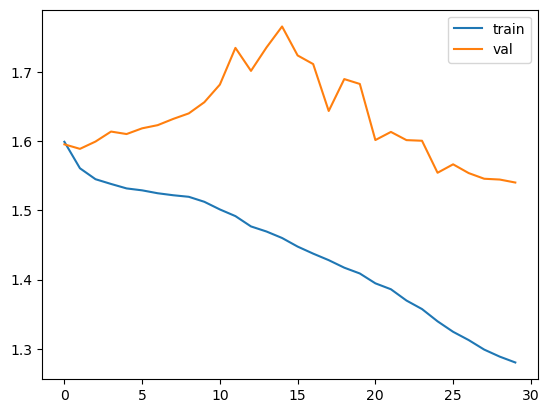

In [89]:
## Plot the loss and the val_loss
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"] , label="val loss")
plt.legend(["train","val"])

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix
y_pred = np.round(model.predict(X_test))

  1/258 [..............................] - ETA: 6s

258/258 [==============================] - 1s 3ms/step


In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1056
           1       1.00      0.01      0.03      1330
           2       0.00      0.00      0.00      2006
           3       0.00      0.00      0.00      1553
           4       0.00      0.00      0.00      2287

   micro avg       1.00      0.00      0.00      8232
   macro avg       0.20      0.00      0.01      8232
weighted avg       0.16      0.00      0.00      8232
 samples avg       0.00      0.00      0.00      8232



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
cnf = confusion_matrix(np.argmax(list(y_test.values),
                       axis=1), np.argmax(y_pred, axis=1))

In [101]:
y_test.values

array([[0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

<AxesSubplot:>

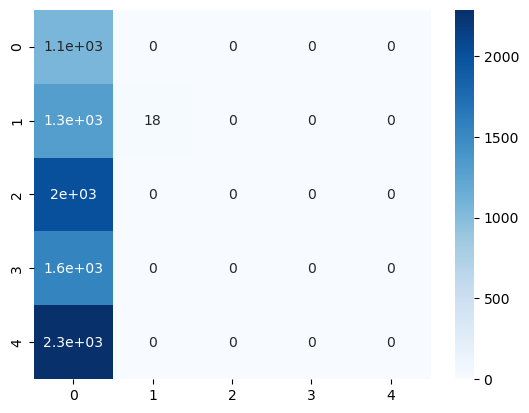

In [ ]:
# sns.heatmap(cnf, cmap="Blues", annot=True)